### Introduction

The dataset used for this project was sourced from: https://www.kaggle.com/datasets/guanhaopeng/uk-used-car-market

The data includes approximately 1,000,0000 records representing adverts from one the UK's largest automotive online marketplace and classified advertising sites, Auto Trader. This includes features such as make, model, trim, year of registration, price and more.


### Objective

This project will look at creating a machine learning regression model to predict the value of a vehicle based on provided information. The intention is to deploy this model as part of a web application so that visitors to the app can get accurate valuations of the vehicle.

In [483]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import optuna

import json
import pickle
import os

### 1. Basic Data Cleaning

In [295]:
# Import the data from the CSV
raw_car_data = pd.read_csv('data/all_car_adverts.csv', index_col=0)

In [296]:
# Display head of the df
pd.set_option('display.max_columns', None)
raw_car_data.head()

,make,model,variant,car_price,car_badges,car_title,car_sub_title,car_attention_grabber,car_specs,car_seller,car_seller_rating,car_seller_location,year,reg,body_type,miles,engine_vol,engine_size,engine_size_unit,transmission,feul_type,num_owner,ulez,full_service,part_service,part_warranty,full_dealership,first_year_road_tax,brand_new,finance_available,discounted
0,AC,Cobra,NaN,89995.0,NaN,AC Cobra,4.9 MK IV CRS 2dr,GENUINE AC COBRA CRS 522 BHP,"2001 (X reg), Convertible, 14,400 miles, 4.9L,...",Private seller,NaN,watford,2001,X reg,convertible,14400.0,4.9,225.0,bhp,manual,petrol,5.0,0,0,0,0,0,0,0,0,0
1,AC,Cobra,NaN,92500.0,'',AC Cobra,378 - MkIV,PHYSICAL CAR!,"2019 (T reg), Convertible, 650 miles, Manual, ...",Boss Motor Company Limited,5.0,chesham,2019,T reg,convertible,650.0,NaN,NaN,NaN,manual,petrol,NaN,0,0,0,0,0,0,0,0,0
2,AC,Cobra,NaN,109995.0,'',AC Cobra,MK1V 212 SC. 3.5 V8 350 BHP LOTUS TWIN TURBO. ...,FULL CARBON FIBRE BODY.,"2000 (X reg), Convertible, 21,600 miles, 3.5L,...",PREMIER GT LIMITED,4.8,pulborough,2000,X reg,convertible,21600.0,3.5,NaN,NaN,manual,petrol,3.0,0,0,0,0,0,0,0,0,0
3,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV 2dr,ABSOLUTELY STUNNING,"1989 (F reg), Convertible, 2,750 miles, Manual...",TOP 555 LIMITED,5.0,oakham,1989,F reg,convertible,2750.0,NaN,NaN,NaN,manual,petrol,NaN,0,0,0,0,0,0,0,0,0
4,AC,Cobra,NaN,124950.0,'',AC Cobra,302 MKIV With Factory Lightweight Engine 5.0 2dr,'STAGE 3' SVO ENGINE,"1989 (E reg), Convertible, 15,142 miles, 5.0L,...",TOP 555 LIMITED,5.0,oakham,1989,E reg,convertible,15142.0,5.0,NaN,NaN,manual,petrol,NaN,0,0,0,0,0,0,0,0,0


We currently have a 'car_seller' feature, that includes the name of the seller or 'Private seller' if it represents a private sale. We're not interested in seller specific data, so for now, we'll create a new feature called 'private_sale' which will = 1 if it's a private sale, and 0 if not.

In [297]:
# Create the new feature 'private_sale'
raw_car_data['private_sale'] = raw_car_data['car_seller'].apply(lambda x: 1 if x == 'Private seller' else 0)

Let's look at the distribution for car prices.

<Axes: xlabel='car_price', ylabel='Count'>

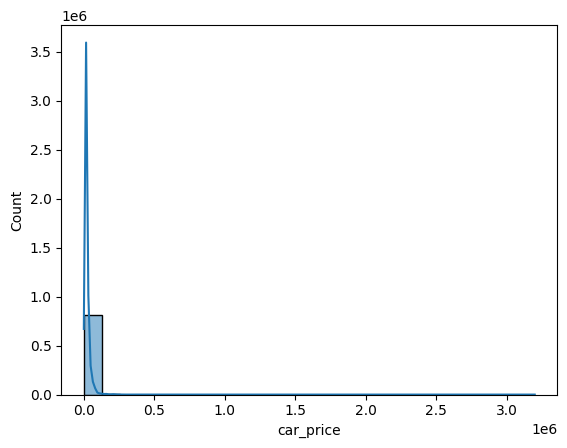

In [298]:
# Plot price distribution
sns.histplot(raw_car_data['car_price'], bins=25, kde=True)

We can see we have a very heavy right skew. We can likely reduce this with feature engineering later, by doing something like a log transform. However, outliers at the higher end of the price values may still reduce the accuracy of the model. Let's remove outliers at the higher and lower end of price values using a simple percentile approach.

In [299]:
# Define upper and lower percentiles (1% and 99%)
lower_percentile = raw_car_data['car_price'].quantile(0.01)
upper_percentile = raw_car_data['car_price'].quantile(0.99)

# Filter the DataFrame to remove outliers based on precentiles
raw_car_data = raw_car_data[(raw_car_data['car_price'] >= lower_percentile) & (raw_car_data['car_price'] <= upper_percentile)]

We have several features that will not help the performance of the model. This includes features like 'car_attention_gabber' - a headline for the advert that can take any text string value. Let's drop these features, including 'car_seller' now that we have the 'private_sale' feature.

In [300]:
# Define columns to drop
columns_to_drop = ['car_badges',
                   'car_title',
                   'car_sub_title',
                   'car_attention_grabber',
                   'car_specs',
                   'car_seller',
                   'car_seller_rating',
                   'car_seller_location',
                   'reg',
                   'part_warranty',
                   'full_dealership',
                   'first_year_road_tax',
                   'brand_new',
                   'finance_available',
                   'discounted'
                   ]

cleaned_data = raw_car_data.drop(columns=columns_to_drop)

Engine power is defined in 2 different units: BHP and PS. We want to standardise this for the model. Let's create a new feature that converts any values provided in PS to BHP, based on the unit defined in 'engine_size_unit'.

In [301]:
# Conversion factor from PS to BHP
ps_to_bhp = 1 / 1.01387

# Create the new feature 'engine_power' and round to nearest integer
cleaned_data['engine_power'] = cleaned_data.apply(
    lambda row: round(row['engine_size'] * ps_to_bhp) if row['engine_size_unit'] == 'ps' else row['engine_size'],
    axis=1
)

# Drop the old power features
old_power_cols = ['engine_size',
                  'engine_size_unit',
                  ]

cleaned_data.drop(columns=old_power_cols, inplace=True)

Some of the year values are non-numeric, so we need to identify these records and drop them. Then create a new featured called age based of the current year. Then we can drop the year feature.

In [302]:
# Convert 'year' to numeric values, setting errors to 'coerce' which will replace non-numeric values with NaN
cleaned_data['year'] = pd.to_numeric(cleaned_data['year'], errors='coerce')

# Drop rows with NaN values in 'year' column
cleaned_data = cleaned_data.dropna(subset=['year'])

# Convert 'year' back to integers
cleaned_data.loc[:, 'year'] = cleaned_data['year'].astype(int)

# Calculate the age
cleaned_data['age'] = 2024 - cleaned_data['year']

# Drop year column
cleaned_data.drop(columns='year', inplace=True)

Now let's just correct the typo for feul_type.

In [303]:
cleaned_data.rename(columns={'feul_type': 'fuel_type'}, inplace=True)

Let's take a look at the dataframe after cleaning:

In [304]:
cleaned_data.head()

,make,model,variant,car_price,body_type,miles,engine_vol,transmission,fuel_type,num_owner,ulez,full_service,part_service,private_sale,engine_power,age
0,AC,Cobra,NaN,89995.0,convertible,14400.0,4.9,manual,petrol,5.0,0,0,0,1,225.0,23.0
1,AC,Cobra,NaN,92500.0,convertible,650.0,NaN,manual,petrol,NaN,0,0,0,0,NaN,5.0
7,AC,NaN,MK IV CRS,89995.0,convertible,14400.0,4.9,manual,petrol,5.0,0,0,0,1,225.0,23.0
8,Abarth,124 Spider,GT,24275.0,convertible,10313.0,1.4,automatic,petrol,2.0,1,0,0,0,167.0,5.0
9,Abarth,124 Spider,GT,24275.0,convertible,10313.0,1.4,automatic,petrol,2.0,1,0,0,0,167.0,5.0


In [305]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 754910 entries, 0 to 818455
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   make          754910 non-null  object 
 1   model         754666 non-null  object 
 2   variant       752901 non-null  object 
 3   car_price     754910 non-null  float64
 4   body_type     754238 non-null  object 
 5   miles         748222 non-null  float64
 6   engine_vol    743587 non-null  float64
 7   transmission  754738 non-null  object 
 8   fuel_type     754749 non-null  object 
 9   num_owner     433229 non-null  float64
 10  ulez          754910 non-null  int64  
 11  full_service  754910 non-null  int64  
 12  part_service  754910 non-null  int64  
 13  private_sale  754910 non-null  int64  
 14  engine_power  751387 non-null  float64
 15  age           754910 non-null  float64
dtypes: float64(6), int64(4), object(6)
memory usage: 97.9+ MB


This is looking better, but we still need to deal with missing values.

### 2. Handling Missing Values

Let's first check how many values are missing by feature.

In [306]:
cleaned_data.isnull().sum()

make                 0
model              244
variant           2009
car_price            0
body_type          672
miles             6688
engine_vol       11323
transmission       172
fuel_type          161
num_owner       321681
ulez                 0
full_service         0
part_service         0
private_sale         0
engine_power      3523
age                  0
dtype: int64

Initial observations:
1. Nearly 40% of the data has no value for number of previous owners, so we'll drop this
2. Not all vehicles have a variant, so for those with missing values, we'll set variant = None
3. For records without a value for model, we'll drop, as this is very significant but we only have 303 of them
4. As mileage will likely be critical for predictions, we'll drop any records without a value for this feature


In [307]:
# Create copy of raw data
cleaned_data_missing = cleaned_data.copy()

# Drop records with no mileage
cleaned_data_missing = cleaned_data_missing.dropna(subset='miles')

# Fill null variant values with 'None'
cleaned_data_missing['variant'] = cleaned_data_missing['variant'].fillna('None')

# Drop number of previous owners
cleaned_data_missing = cleaned_data_missing.drop(columns='num_owner')

# Drop records with null values for 'model'
cleaned_data_missing = cleaned_data_missing.dropna(subset=['model'])

We can now check missing values again.

In [308]:
cleaned_data_missing.isnull().sum()

make                0
model               0
variant             0
car_price           0
body_type         641
miles               0
engine_vol      10954
transmission      165
fuel_type         156
ulez                0
full_service        0
part_service        0
private_sale        0
engine_power     3463
age                 0
dtype: int64

We can see we still have features with siginficant missing value counts. Most of these are vehicle specifications, that have likely not been including in the advert, but are standard across vehicle of the same Make, Model and Age. For this reason, we can impute these spec values (engine_vol, engine_power, 'body_type', 'transmission', and 'fuel_type) by grouping all records where these values do exist for a give combination of make, model, variant and year, and taking the mode (most frequent).

In [309]:
# Function to impute missing values within groups for multiple columns using transform
def impute_missing_spec_values(df, group_cols, target_cols):
    for col in target_cols:
        df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
    return df

# Columns to impute
target_columns = ['engine_vol', 'engine_power', 'body_type', 'transmission', 'fuel_type']

# Impute missing values for the target columns
imputed_car_data = impute_missing_spec_values(cleaned_data_missing, ['make', 'model', 'variant', 'age'], target_columns)

/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_16033/1419409344.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_16033/1419409344.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
/var/folders/7y/311sp_hx0cd0mpz76xxlrr540000gn/T/ipykernel_16033/141940934

Now let's check the number of missing values again.

In [310]:
imputed_car_data.isnull().sum()

make               0
model              0
variant            0
car_price          0
body_type        108
miles              0
engine_vol      9349
transmission      69
fuel_type         65
ulez               0
full_service       0
part_service       0
private_sale       0
engine_power    1691
age                0
dtype: int64

Great, we've significantly reduced the number of missing values. We'll now have to drop any rows that still have missing values.

In [311]:
imputed_car_data = imputed_car_data.dropna()

Let's double check there are no more missing values:

In [312]:
imputed_car_data.isnull().sum()

make            0
model           0
variant         0
car_price       0
body_type       0
miles           0
engine_vol      0
transmission    0
fuel_type       0
ulez            0
full_service    0
part_service    0
private_sale    0
engine_power    0
age             0
dtype: int64

### 3. Train/Test Split

Now the data has been cleaned, let's create the train/test split.

In [313]:
# Create X and y sets
X = imputed_car_data.copy()
y = imputed_car_data['car_price']

# Drop target feature from X
X.drop(columns=['car_price'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4. Feature Engineering

Let's start by looking at the distributions of numerical features.

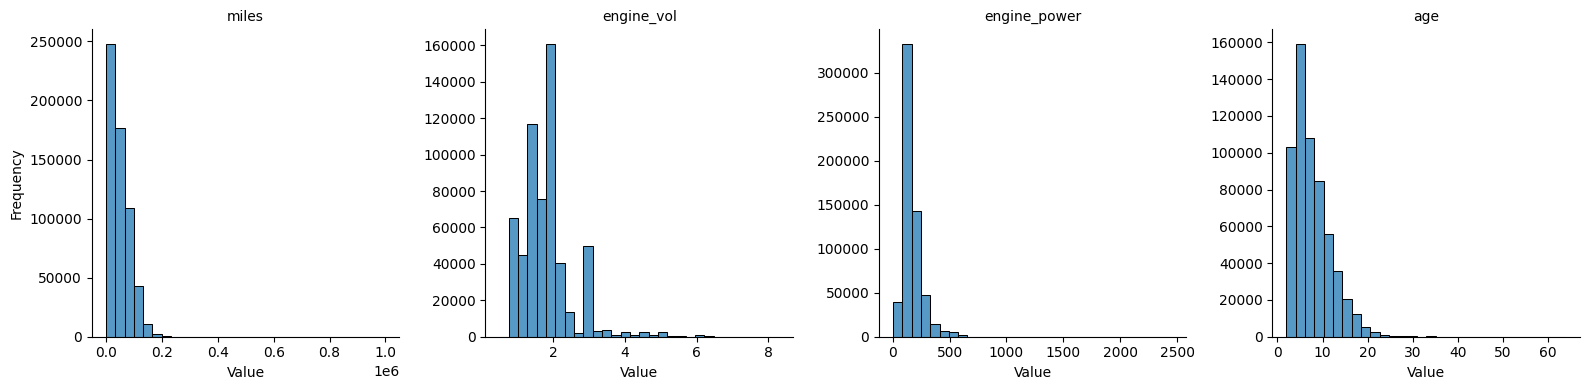

In [314]:
# Define numerical cols
numerical_cols = ['miles', 'engine_vol', 'engine_power', 'age']

# Melt the DataFrame to long format
melted_X_train = X_train[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=30)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

We can see these all have a right skew. Let's try taking the square root of these values to see if we can make the distributions more symmetrical, as most ML algorithms prefer this.

In [315]:
# Define function to apply square root transform
def sqrt_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

In [316]:
# Apply the function to X_train
X_train_cleaned_sqrt = sqrt_of_feature(imputed_car_data, numerical_cols)

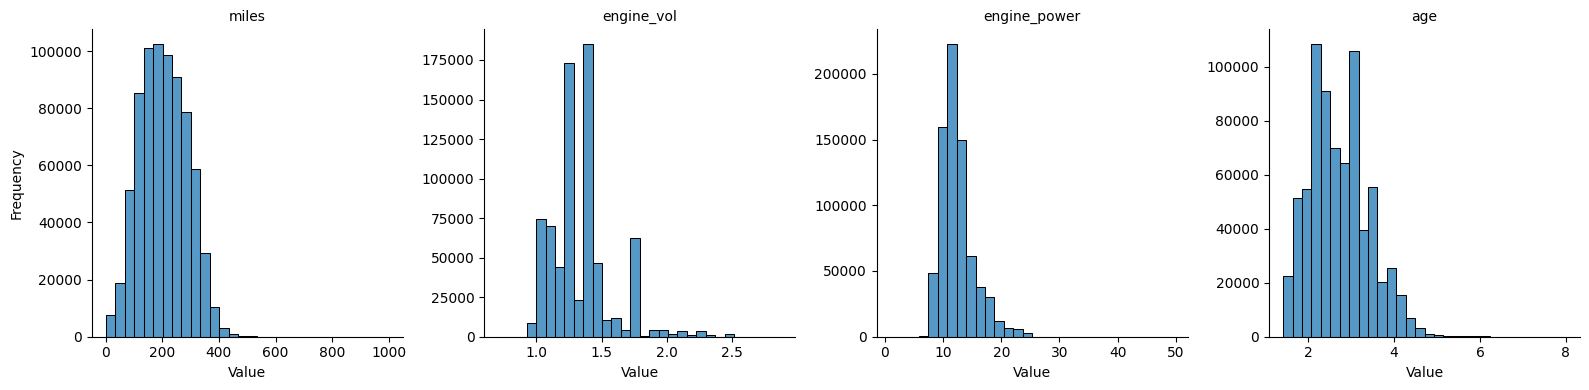

In [317]:
# Plot the updated distributions
melted_X_train = X_train_cleaned_sqrt[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=30)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

Good, these distributions are much closer to symmetrical.

Let's now take a look at the target variable, price.

<Axes: xlabel='car_price', ylabel='Count'>

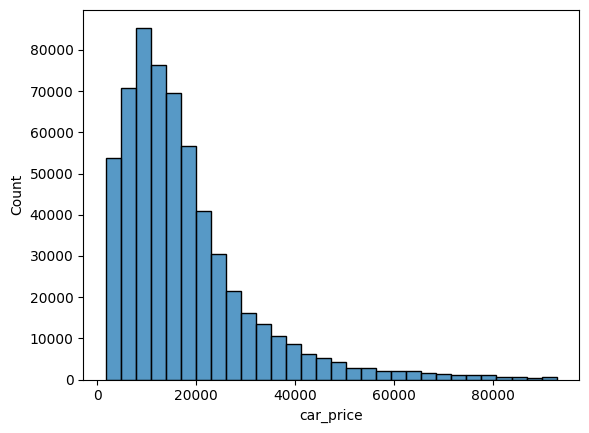

In [318]:
sns.histplot(y_train, bins=30)

We can see a right skew again. This looks to follow a power law, as the tail is long and thin, so let's try taking the log of the feature to make it more symmetrical.

In [319]:
# Define function to apply log transform
def log_of_feature(data):
    return np.log(data)

In [320]:
# Apply the function to target feature
y_train_log = log_of_feature(y_train)

<Axes: xlabel='car_price', ylabel='Count'>

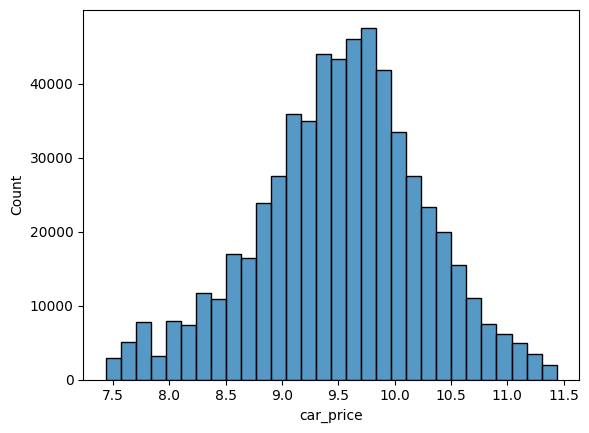

In [321]:
sns.histplot(y_train_log, bins=30)

Great, this looks much more symmetrical!

### 5. Data Pipelines

We now know how we want to preprocess the data for the model, so let's create a pipeline to automate this from now on.

One transformation we haven't yet considered is how we'll deal with the categorical variables make, model and variant. These have thousands of unique values:

In [322]:
print(f'Make unique values: {imputed_car_data['make'].nunique()}')
print(f'Model unique values: {imputed_car_data['model'].nunique()}')
print(f'Variant unique values: {imputed_car_data['variant'].nunique()}')

Make unique values: 80
Model unique values: 919
Variant unique values: 3205


Something like one-hot encoding wouldn't be effective here, as it will increase the feature space massively and make model training difficult. Instead, let's one-hot encode these feature, but then do a PCA on these features to reduce the feature space back down to a predefined number of features.

We'll also scale the numerical features using standard scaler.

In [327]:
# Define binary features
binary_features = ['transmission','ulez', 'full_service', 'part_service', 'private_sale']

# Define one-hot/PCA features
pca_features = ['make', 'model', 'variant']

# Define one-hot features
one_hot_features = ['body_type', 'fuel_type']

# Define numeric features for scaling
numeric_features = ['age','miles', 'engine_vol', 'engine_power']

Now let's define the pipelines. First creating a custom transformer for the sqrt function of the numerical variables.

In [338]:
class SqrtTransformer(FunctionTransformer):
    def __init__(self):
        super().__init__(func=np.sqrt)

    def fit(self, X, y=None):
        # Fit method doesn't need to do anything specific for sqrt
        return self

    def transform(self, X):
        # Apply the square root transformation
        return super().transform(X)

    def get_feature_names_out(self, input_features=None):
        # Simply return the input feature names, as sqrt does not change them
        if input_features is not None:
            return input_features
        else:
            return np.array([])

In [458]:
# Define numerical pipeline
numerical_pipeline = Pipeline([
    ('sqrt', SqrtTransformer()),
    ('scaler', StandardScaler()),
])

# One-hot/PCA piepline
pca_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse_output=True, drop='first', handle_unknown='ignore')),
    ('pca', PCA(n_components=10, svd_solver='arpack'))
])

# Define one-hot pipeline
one_hot_pipeline = Pipeline([
    ('one_hot_encoder', OneHotEncoder(sparse_output=True, drop='first'))
])

# Define binary pipeline
binary_pipeline = Pipeline([
    ('binary_encoder', OrdinalEncoder())
])

preprocess_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numeric_features),
    ('pca', pca_pipeline, pca_features),
    ('one_hot', one_hot_pipeline, one_hot_features),
    ('binary', binary_pipeline, binary_features)
])

We're now ready to use the pipeline to transform X_train.

In [459]:
# Transform X train using the pipeline
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

Let's convert this back to a df so we can inspect the results:

In [341]:
# Create df from process data
X_train_prepared_df = pd.DataFrame(X_train_prepared)
# Update column names
X_train_prepared_df.columns = preprocess_pipeline.get_feature_names_out()

In [342]:
X_train_prepared_df.head()

,numerical__age,numerical__miles,numerical__engine_vol,numerical__engine_power,pca__pca0,pca__pca1,pca__pca2,pca__pca3,pca__pca4,pca__pca5,pca__pca6,pca__pca7,pca__pca8,pca__pca9,one_hot__body_type_car derived van,one_hot__body_type_combi van,one_hot__body_type_convertible,one_hot__body_type_coupe,one_hot__body_type_estate,one_hot__body_type_hatchback,one_hot__body_type_limousine,one_hot__body_type_minibus,one_hot__body_type_mpv,one_hot__body_type_panel van,one_hot__body_type_pickup,one_hot__body_type_pickup double cab car,one_hot__body_type_saloon,one_hot__body_type_suv,one_hot__fuel_type_diesel,one_hot__fuel_type_diesel hybrid,one_hot__fuel_type_diesel plug-in hybrid,one_hot__fuel_type_electric,one_hot__fuel_type_petrol,one_hot__fuel_type_petrol hybrid,one_hot__fuel_type_petrol plug-in hybrid,binary__transmission,binary__ulez,binary__full_service,binary__part_service,binary__private_sale
0,-1.438106,-1.291373,-1.401184,-1.271953,-0.178184,-0.195699,-0.386138,0.741084,-0.442653,-0.158924,-0.090023,0.119297,0.036129,0.051965,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.615254,0.193742,0.315765,0.302906,-0.175145,-0.190117,-0.376678,0.721822,-0.430149,-0.152284,-0.087083,0.114470,0.039129,0.059620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.994704,1.050179,-0.641739,-1.078949,-0.156735,-0.085055,-0.061747,0.082642,0.891996,-0.699014,-0.209403,0.209161,0.034922,0.034251,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.382274,1.127065,0.315765,-0.260887,-0.090298,-0.043229,-0.064723,-0.033674,0.031989,0.054157,0.056946,-0.178343,-0.117401,-0.242194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.382274,0.509868,0.315765,0.071958,-0.073558,-0.018804,-0.015575,0.009318,0.062013,0.066951,0.056749,-0.137729,-0.042871,-0.045051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We now need to create a pipeline for the target feature.

We need to define the inverse function too so we can return predictions back to actual values.

In [383]:
# Define the forward and inverse transformations
log_transformer = FunctionTransformer(
    func=np.log1p,  # Forward transformation
    inverse_func=np.expm1  # Inverse transformation
)

# Define the pipeline
target_pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', StandardScaler())
])

# Create a df to pass to the pipeline from the series
y_train_df = pd.DataFrame(y_train)

y_train_prepared = target_pipeline.fit_transform(y_train_df)

Let's convert y_train_prepared from NumPy array back to a Series so we can use it easily with cross-validation later.

In [387]:
y_train_prepared_series = pd.Series(y_train_prepared.flatten())
y_train_prepared_series.index = y_train.index

### 6. Model Selection

Our data has been preprocesed, so we're now ready to test different models and see which perform best.

We'll test several regression models, using default hyperparameter values for now.

In [349]:
# Define list of regressors to test
regs = [
    ('Linear Regression', LinearRegression()),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBRegressor', XGBRegressor(random_state=42)),
    ('CatBoostRegressor', CatBoostRegressor(random_state=42, silent=True)),
    ('LightGBMRegressor', LGBMRegressor(random_state=42))
]

We'll create a k-fold object so we can use the same folds on each model.

In [351]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=5, shuffle=True, random_state=42)

We need to create a custom scorer function, so we can get the RMSE that's accurate to the actual price values (not the scaled/log transformed values).

Let's create a custom scorer to do this.

In [ ]:
# Define the custom RMSE function
def custom_rmse(y_true, y_pred, pipeline):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    
    # Inverse transform using the pipeline
    y_true_inv = pipeline.inverse_transform(y_true)
    y_pred_inv = pipeline.inverse_transform(y_pred)
    
    # Calculate RMSE
    return np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))

# Create the custom scorer
custom_rmse_scorer = make_scorer(custom_rmse, pipeline=target_pipeline, greater_is_better=False)

In [400]:
# Initialize a dictionary to store the results
reg_results = {}

# Evaluate each regressor using cross-validation
for reg_name, reg in regs:
    print(f'Testing model: {reg_name}')
    cv_rmses = cross_val_score(reg, X_train_prepared, y_train_prepared.ravel(), cv=reg_kf, scoring=custom_rmse_scorer, n_jobs=-1)
    reg_results[reg_name] = cv_rmses
    
# Convert the results to a DataFrame
reg_cv_scores_df = pd.DataFrame(reg_results)

Testing model: Linear Regression
Testing model: SGD Regressor


KeyboardInterrupt: 

We can now plot the CV results with a box plot to get a good visualisation of the results.

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

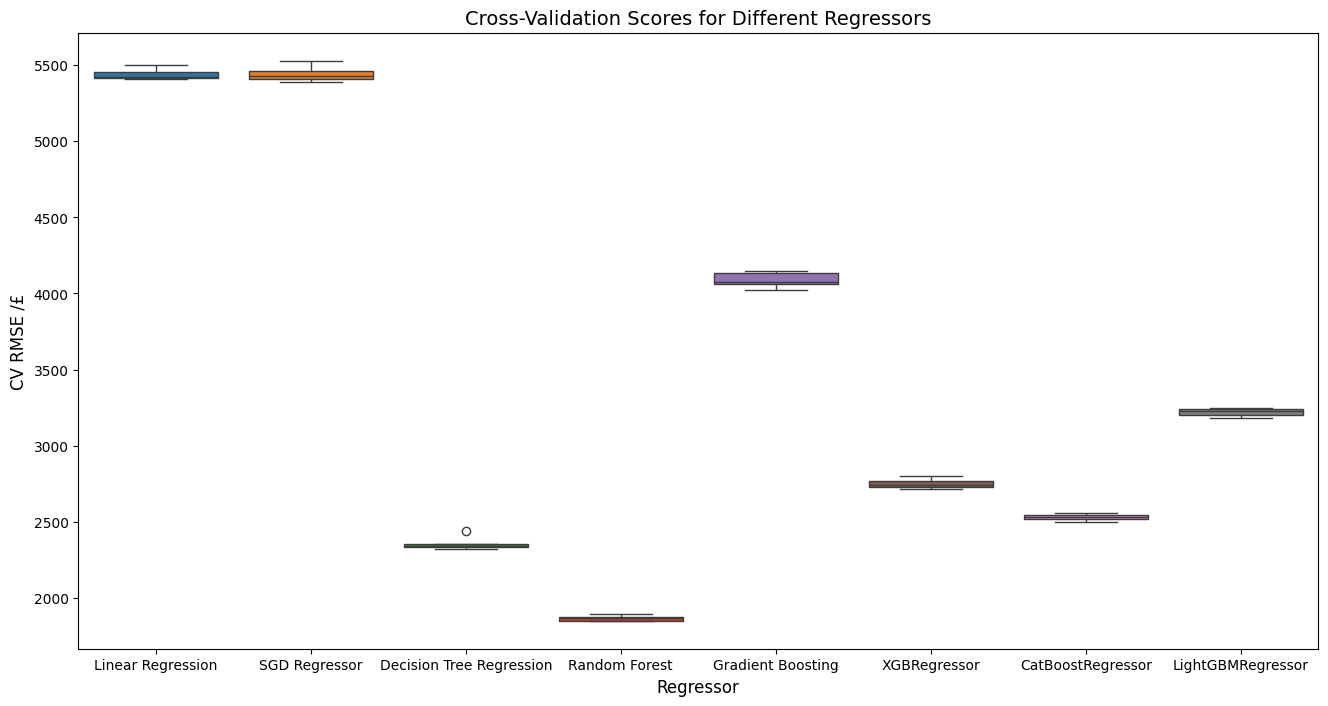

In [357]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE /£', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

We can see the linear regressors peformed poorly, so let's do this plot again without them so we can zoom in on the others.

In [358]:
# Create new results dictionary without linears
reg_results_2 = {key:value for key, value in reg_results.items() if key not in ['Linear Regression', 'SGD Regressor']}
# Create df from dict
reg_results_2_df = pd.DataFrame(reg_results_2)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

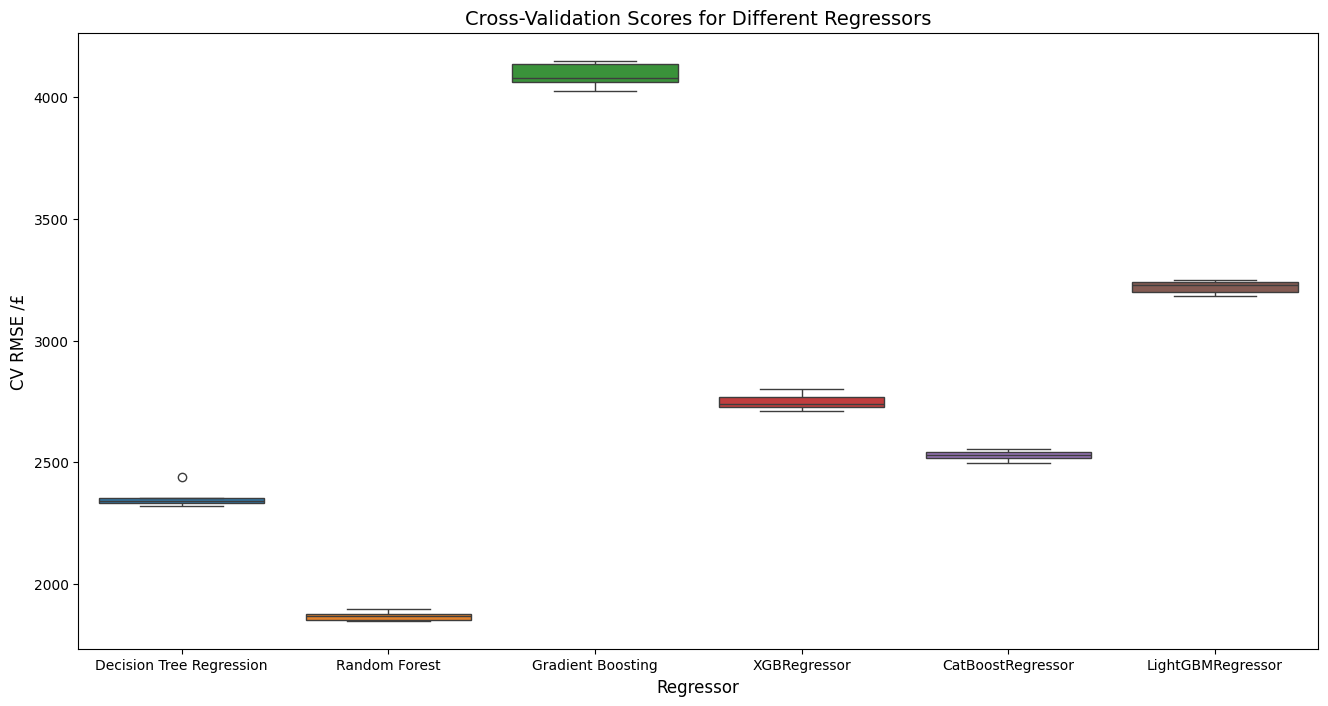

In [359]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_results_2_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE /£', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

We can see that the random forest model performed much better than the other models, so we'll proceed with this.

### 7. Hyperparameter Tuning

As this model will be deployed on Heroku, we need to find a balance between high predictive power and complexity/size to remain budget friendly. Random forest models trained on larger/complex datasets can easily reach several GBs in size after binarisation.

We'll limit the complexity of the model by limiting the value of hyperparameters during our tuning.

To tune hyperparameters, we'll use Optuna. To make the process more efficient, we'll take only a sample of the training data. This will make fitting the model much faster each time it is fitted through tuning, while hopefully not reducing the accruacy of the model.

In [414]:
# Take a random sample of 15% of the training data
X_train_sampled = X_train_prepared_df.sample(frac=0.15, random_state=42)

# Create a series for y for the corresponding X data
y_train_sampled = y_train_prepared[X_train_sampled.index]

# Create train/test samples for study
X_train_study, X_test_study, y_train_study, y_test_study = train_test_split(X_train_sampled, y_train_sampled, test_size=0.2, random_state=42)

In [502]:
# Create objective function
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 5, 30) # Limit parameters to keep size of model reasonable
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    # Create the model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    
    # Perform cross-validation to evaluate the model
    cv_rmse = cross_val_score(rf, X_train_sampled, y_train_sampled.ravel(), cv=3, scoring=custom_rmse_scorer, n_jobs=-1)
    
    # Return the average RMSE across folds
    return cv_rmse.mean()

In [503]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=50, show_progress_bar=False, n_jobs=-1)

[I 2024-08-09 21:57:32,355] A new study created in memory with name: no-name-4b71216f-263a-493c-a39a-71d903188600


[I 2024-08-09 21:57:32,355] A new study created in memory with name: no-name-4b71216f-263a-493c-a39a-71d903188600
[I 2024-08-09 21:57:32,355] A new study created in memory with name: no-name-4b71216f-263a-493c-a39a-71d903188600


[I 2024-08-09 21:57:40,896] Trial 0 finished with value: 3203.657308068061 and parameters: {'n_estimators': 11, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 0 with value: 3203.657308068061.


[I 2024-08-09 21:57:40,896] Trial 0 finished with value: 3203.657308068061 and parameters: {'n_estimators': 11, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 0 with value: 3203.657308068061.
[I 2024-08-09 21:57:40,896] Trial 0 finished with value: 3203.657308068061 and parameters: {'n_estimators': 11, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 0 with value: 3203.657308068061.


[I 2024-08-09 21:57:41,239] Trial 1 finished with value: 3189.8447488795205 and parameters: {'n_estimators': 12, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 3189.8447488795205.


[I 2024-08-09 21:57:41,239] Trial 1 finished with value: 3189.8447488795205 and parameters: {'n_estimators': 12, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 3189.8447488795205.
[I 2024-08-09 21:57:41,239] Trial 1 finished with value: 3189.8447488795205 and parameters: {'n_estimators': 12, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 1 with value: 3189.8447488795205.


[I 2024-08-09 21:57:49,978] Trial 3 finished with value: 3488.386080144544 and parameters: {'n_estimators': 11, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 3189.8447488795205.


[I 2024-08-09 21:57:49,978] Trial 3 finished with value: 3488.386080144544 and parameters: {'n_estimators': 11, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 3189.8447488795205.
[I 2024-08-09 21:57:49,978] Trial 3 finished with value: 3488.386080144544 and parameters: {'n_estimators': 11, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 3189.8447488795205.


[I 2024-08-09 21:57:50,329] Trial 2 finished with value: 3036.416117097169 and parameters: {'n_estimators': 23, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 2 with value: 3036.416117097169.


[I 2024-08-09 21:57:50,329] Trial 2 finished with value: 3036.416117097169 and parameters: {'n_estimators': 23, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 2 with value: 3036.416117097169.
[I 2024-08-09 21:57:50,329] Trial 2 finished with value: 3036.416117097169 and parameters: {'n_estimators': 23, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 2 with value: 3036.416117097169.


[I 2024-08-09 21:57:54,576] Trial 9 finished with value: 6114.34288079153 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 2 with value: 3036.416117097169.


[I 2024-08-09 21:57:54,576] Trial 9 finished with value: 6114.34288079153 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 2 with value: 3036.416117097169.
[I 2024-08-09 21:57:54,576] Trial 9 finished with value: 6114.34288079153 and parameters: {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 2 with value: 3036.416117097169.


[I 2024-08-09 21:57:58,085] Trial 5 finished with value: 2955.292209141771 and parameters: {'n_estimators': 18, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:57:58,085] Trial 5 finished with value: 2955.292209141771 and parameters: {'n_estimators': 18, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 5 with value: 2955.292209141771.
[I 2024-08-09 21:57:58,085] Trial 5 finished with value: 2955.292209141771 and parameters: {'n_estimators': 18, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:57:59,455] Trial 4 finished with value: 3810.6194912751257 and parameters: {'n_estimators': 16, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:57:59,455] Trial 4 finished with value: 3810.6194912751257 and parameters: {'n_estimators': 16, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.
[I 2024-08-09 21:57:59,455] Trial 4 finished with value: 3810.6194912751257 and parameters: {'n_estimators': 16, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:04,869] Trial 6 finished with value: 3568.9115667103274 and parameters: {'n_estimators': 5, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:04,869] Trial 6 finished with value: 3568.9115667103274 and parameters: {'n_estimators': 5, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.
[I 2024-08-09 21:58:04,869] Trial 6 finished with value: 3568.9115667103274 and parameters: {'n_estimators': 5, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:11,228] Trial 8 finished with value: 4778.503100062052 and parameters: {'n_estimators': 14, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:11,228] Trial 8 finished with value: 4778.503100062052 and parameters: {'n_estimators': 14, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.
[I 2024-08-09 21:58:11,228] Trial 8 finished with value: 4778.503100062052 and parameters: {'n_estimators': 14, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:15,596] Trial 10 finished with value: 3494.4372385074216 and parameters: {'n_estimators': 10, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:15,596] Trial 10 finished with value: 3494.4372385074216 and parameters: {'n_estimators': 10, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.
[I 2024-08-09 21:58:15,596] Trial 10 finished with value: 3494.4372385074216 and parameters: {'n_estimators': 10, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 5 with value: 2955.292209141771.


[I 2024-08-09 21:58:16,741] Trial 11 finished with value: 2846.990025964824 and parameters: {'n_estimators': 17, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:16,741] Trial 11 finished with value: 2846.990025964824 and parameters: {'n_estimators': 17, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:16,741] Trial 11 finished with value: 2846.990025964824 and parameters: {'n_estimators': 17, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:20,270] Trial 7 finished with value: 3592.449415893134 and parameters: {'n_estimators': 27, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:20,270] Trial 7 finished with value: 3592.449415893134 and parameters: {'n_estimators': 27, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:20,270] Trial 7 finished with value: 3592.449415893134 and parameters: {'n_estimators': 27, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:29,601] Trial 12 finished with value: 2954.31493882697 and parameters: {'n_estimators': 18, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:29,601] Trial 12 finished with value: 2954.31493882697 and parameters: {'n_estimators': 18, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:29,601] Trial 12 finished with value: 2954.31493882697 and parameters: {'n_estimators': 18, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:30,003] Trial 13 finished with value: 5239.928681164306 and parameters: {'n_estimators': 23, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:30,003] Trial 13 finished with value: 5239.928681164306 and parameters: {'n_estimators': 23, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:30,003] Trial 13 finished with value: 5239.928681164306 and parameters: {'n_estimators': 23, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:35,382] Trial 15 finished with value: 3707.0175521859314 and parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:35,382] Trial 15 finished with value: 3707.0175521859314 and parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:35,382] Trial 15 finished with value: 3707.0175521859314 and parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:36,389] Trial 14 finished with value: 2957.53716491564 and parameters: {'n_estimators': 13, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:36,389] Trial 14 finished with value: 2957.53716491564 and parameters: {'n_estimators': 13, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:36,389] Trial 14 finished with value: 2957.53716491564 and parameters: {'n_estimators': 13, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:42,360] Trial 16 finished with value: 4032.2392521353117 and parameters: {'n_estimators': 16, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:42,360] Trial 16 finished with value: 4032.2392521353117 and parameters: {'n_estimators': 16, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:42,360] Trial 16 finished with value: 4032.2392521353117 and parameters: {'n_estimators': 16, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:44,653] Trial 18 finished with value: 3361.8164986953275 and parameters: {'n_estimators': 10, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:44,653] Trial 18 finished with value: 3361.8164986953275 and parameters: {'n_estimators': 10, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:44,653] Trial 18 finished with value: 3361.8164986953275 and parameters: {'n_estimators': 10, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:45,464] Trial 17 finished with value: 3465.17998997071 and parameters: {'n_estimators': 22, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:45,464] Trial 17 finished with value: 3465.17998997071 and parameters: {'n_estimators': 22, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:45,464] Trial 17 finished with value: 3465.17998997071 and parameters: {'n_estimators': 22, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:48,851] Trial 19 finished with value: 2879.3964512546972 and parameters: {'n_estimators': 9, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:58:48,851] Trial 19 finished with value: 2879.3964512546972 and parameters: {'n_estimators': 9, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:58:48,851] Trial 19 finished with value: 2879.3964512546972 and parameters: {'n_estimators': 9, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:09,512] Trial 22 finished with value: 2847.3396626854105 and parameters: {'n_estimators': 22, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:09,512] Trial 22 finished with value: 2847.3396626854105 and parameters: {'n_estimators': 22, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:09,512] Trial 22 finished with value: 2847.3396626854105 and parameters: {'n_estimators': 22, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:10,689] Trial 20 finished with value: 3180.546710230578 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:10,689] Trial 20 finished with value: 3180.546710230578 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:10,689] Trial 20 finished with value: 3180.546710230578 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:11,928] Trial 23 finished with value: 2850.6004541830407 and parameters: {'n_estimators': 21, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:12,086] Trial 21 finished with value: 3261.2951142097904 and parameters: {'n_estimators': 30, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:11,928] Trial 23 finished with value: 2850.6004541830407 and parameters: {'n_estimators': 21, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:11,928] Trial 23 finished with value: 2850.6004541830407 and parameters: {'n_estimators': 21, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:12,086] Trial 21 finished with value: 3261.2951142097904 and parameters: {'n_estimators': 30, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:12,086] Trial 21 finished with value: 3261.2951142097904 and parameters: {'n_estimators': 30, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:33,906] Trial 25 finished with value: 2853.090749920328 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:33,906] Trial 25 finished with value: 2853.090749920328 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.
[I 2024-08-09 21:59:33,906] Trial 25 finished with value: 2853.090749920328 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 11 with value: 2846.990025964824.


[I 2024-08-09 21:59:34,917] Trial 24 finished with value: 2781.275061360062 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:34,917] Trial 24 finished with value: 2781.275061360062 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 21:59:34,917] Trial 24 finished with value: 2781.275061360062 and parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:37,119] Trial 26 finished with value: 2789.6036396881423 and parameters: {'n_estimators': 20, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:37,119] Trial 26 finished with value: 2789.6036396881423 and parameters: {'n_estimators': 20, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 21:59:37,119] Trial 26 finished with value: 2789.6036396881423 and parameters: {'n_estimators': 20, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:44,473] Trial 27 finished with value: 2840.316490584533 and parameters: {'n_estimators': 29, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:44,473] Trial 27 finished with value: 2840.316490584533 and parameters: {'n_estimators': 29, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 21:59:44,473] Trial 27 finished with value: 2840.316490584533 and parameters: {'n_estimators': 29, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:55,381] Trial 31 finished with value: 2945.86904005237 and parameters: {'n_estimators': 6, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:55,381] Trial 31 finished with value: 2945.86904005237 and parameters: {'n_estimators': 6, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 21:59:55,381] Trial 31 finished with value: 2945.86904005237 and parameters: {'n_estimators': 6, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:59,635] Trial 28 finished with value: 2839.881043949826 and parameters: {'n_estimators': 30, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 21:59:59,635] Trial 28 finished with value: 2839.881043949826 and parameters: {'n_estimators': 30, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 21:59:59,635] Trial 28 finished with value: 2839.881043949826 and parameters: {'n_estimators': 30, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:00,513] Trial 29 finished with value: 2847.8697982263707 and parameters: {'n_estimators': 29, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:00,513] Trial 29 finished with value: 2847.8697982263707 and parameters: {'n_estimators': 29, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:00,513] Trial 29 finished with value: 2847.8697982263707 and parameters: {'n_estimators': 29, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:05,225] Trial 30 finished with value: 2785.4824739227734 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:05,225] Trial 30 finished with value: 2785.4824739227734 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:05,225] Trial 30 finished with value: 2785.4824739227734 and parameters: {'n_estimators': 26, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:20,471] Trial 32 finished with value: 2846.9573637178087 and parameters: {'n_estimators': 30, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:20,471] Trial 32 finished with value: 2846.9573637178087 and parameters: {'n_estimators': 30, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:20,471] Trial 32 finished with value: 2846.9573637178087 and parameters: {'n_estimators': 30, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:22,692] Trial 35 finished with value: 2886.7122171293486 and parameters: {'n_estimators': 20, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:22,692] Trial 35 finished with value: 2886.7122171293486 and parameters: {'n_estimators': 20, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:22,692] Trial 35 finished with value: 2886.7122171293486 and parameters: {'n_estimators': 20, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:26,652] Trial 34 finished with value: 2859.010473994656 and parameters: {'n_estimators': 29, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:26,652] Trial 34 finished with value: 2859.010473994656 and parameters: {'n_estimators': 29, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:26,652] Trial 34 finished with value: 2859.010473994656 and parameters: {'n_estimators': 29, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:27,144] Trial 33 finished with value: 2834.1761628323325 and parameters: {'n_estimators': 30, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:27,144] Trial 33 finished with value: 2834.1761628323325 and parameters: {'n_estimators': 30, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:27,144] Trial 33 finished with value: 2834.1761628323325 and parameters: {'n_estimators': 30, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:45,055] Trial 38 finished with value: 2868.1845433636904 and parameters: {'n_estimators': 16, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:45,055] Trial 38 finished with value: 2868.1845433636904 and parameters: {'n_estimators': 16, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:45,055] Trial 38 finished with value: 2868.1845433636904 and parameters: {'n_estimators': 16, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:46,080] Trial 36 finished with value: 2903.887712971529 and parameters: {'n_estimators': 25, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:46,080] Trial 36 finished with value: 2903.887712971529 and parameters: {'n_estimators': 25, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:46,080] Trial 36 finished with value: 2903.887712971529 and parameters: {'n_estimators': 25, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:49,838] Trial 37 finished with value: 2855.1481832610243 and parameters: {'n_estimators': 26, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:49,838] Trial 37 finished with value: 2855.1481832610243 and parameters: {'n_estimators': 26, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:49,838] Trial 37 finished with value: 2855.1481832610243 and parameters: {'n_estimators': 26, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:57,110] Trial 39 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:00:57,110] Trial 39 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:00:57,110] Trial 39 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:14,260] Trial 40 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:14,260] Trial 40 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:14,260] Trial 40 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:14,886] Trial 41 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:14,886] Trial 41 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:14,886] Trial 41 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:19,626] Trial 42 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:19,626] Trial 42 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:19,626] Trial 42 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:27,934] Trial 43 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:27,934] Trial 43 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:27,934] Trial 43 finished with value: 2815.7784372161427 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:42,267] Trial 44 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:42,267] Trial 44 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:42,267] Trial 44 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:42,706] Trial 45 finished with value: 2816.0902525647907 and parameters: {'n_estimators': 25, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:42,706] Trial 45 finished with value: 2816.0902525647907 and parameters: {'n_estimators': 25, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:42,706] Trial 45 finished with value: 2816.0902525647907 and parameters: {'n_estimators': 25, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:47,324] Trial 46 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:47,324] Trial 46 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:47,324] Trial 46 finished with value: 2816.7660785577955 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:51,136] Trial 47 finished with value: 2879.428059229447 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:51,136] Trial 47 finished with value: 2879.428059229447 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:51,136] Trial 47 finished with value: 2879.428059229447 and parameters: {'n_estimators': 25, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:59,392] Trial 48 finished with value: 2879.419073432198 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:59,480] Trial 49 finished with value: 3447.2074755842805 and parameters: {'n_estimators': 24, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 24 with value: 2781.275061360062.


[I 2024-08-09 22:01:59,392] Trial 48 finished with value: 2879.419073432198 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:59,392] Trial 48 finished with value: 2879.419073432198 and parameters: {'n_estimators': 26, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:59,480] Trial 49 finished with value: 3447.2074755842805 and parameters: {'n_estimators': 24, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 24 with value: 2781.275061360062.
[I 2024-08-09 22:01:59,480] Trial 49 finished with value: 3447.2074755842805 and parameters: {'n_estimators': 24, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 24 with value: 2781.275061360062.


In [504]:
best_params = study.best_params
print(f'Best parameters: {study.best_params}')
print(f'Best RMSE: {study.best_value}')

Best parameters: {'n_estimators': 20, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True}
Best RMSE: 2781.275061360062


### 8. Model Evaluation

OK, we have our best parameters and a preliminary score. Let's create the model using these params and then use cross-validation on the entire test set (as it's only been tested on the sample so far) to get a better understanding of its performance.

In [505]:
# Create the model with the best hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
    n_jobs=-1
)

# Cross-validate the model using the whole training set
cv_rmse_scores = cross_val_score(rf_model, X_train_prepared, y_train_prepared.ravel(), cv=10, scoring=custom_rmse_scorer, n_jobs=-1)

# Calculate the mean and standard deviation of RMSE scores
mean_rmse = cv_rmse_scores.mean()

print(f'Mean RMSE across folds: {mean_rmse}')

Mean RMSE across folds: 1948.3578444529298


Great, let's now fit the final model.

In [506]:
# Fit the model on the entire training set
rf_model.fit(X_train_prepared, y_train_prepared.ravel())

RandomForestRegressor(max_depth=20, min_samples_split=3, n_estimators=20,
                      n_jobs=-1, random_state=42)

It's now time to test the model with the test dataset!

In [507]:
# Prepare the test set
X_test_prepared = preprocess_pipeline.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [508]:
# Make predictions on the test data
y_test_pred = rf_model.predict(X_train_prepared)

In [509]:
# Make predictions on the test data
y_test_pred = rf_model.predict(X_test_prepared)

y_test_pred_real = target_pipeline.inverse_transform(y_test_pred.reshape(-1, 1))

# Calculate custom RMSE using your custom scorer
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_real))

print(f'Test RMSE: {test_rmse}')

Test RMSE: 1896.0628774979539


This is a good result! It's very much inline with the cross-validation scores on the training set, in fact, slightly better. We're now done with creating the model.

### 9. Saving Trained Model and Pipelines

We can now save the trained model by exporting pkl files. We also need to save the preprocessing pipeline and target variable pipeline so we can feed values into the model and then convert predictions back to meaningful values.

In [510]:
with open('model/model.pkl', 'wb') as file1:
    pickle.dump(rf_model, file1, protocol=-1)

with open('model/pipeline.pkl', 'wb') as file2:
    pickle.dump(preprocess_pipeline, file2)

with open('model/target_pipeline.pkl', 'wb') as file3:
    pickle.dump(target_pipeline, file3)

As mentioned previously, we wanted to balance model complexity and model size to keep our app budget friendly when it comes to deployment. Let's check the size of the saved model. The cheaper Heroku plans have 512MB of RAM available, so we need to keep the model below this, with some space reserved for the rest of the application.

In [511]:
# Get the file size in bytes
file_size_bytes = os.path.getsize('model/model.pkl')

# Convert bytes to megabytes (MB)
file_size_mb = file_size_bytes / (1024 * 1024)

# Print the file size
print(f"Model size: {file_size_mb:.2f} MB")

Model size: 242.30 MB


### 10. Creating Car Data Library

We need to create a library of options users of the web app can select. For example, if a user selects the make 'Ford' from a dropdown, the dropdown for model should then be populated with all models for Ford vehicles from the dataset.

This won't include every vehicle, but given we have close to 1,000,000 records, it should contain the large majority of more recent common vehicles within the UK.

To do this, let's create a JSON file that defines these vehicles configurations which we can load in the web app.

In [498]:
# Create nested dictionary
nested_dict = {}
for i, row in imputed_car_data.iterrows():
    make = row['make']
    model = row['model']
    variant = row['variant']
    details = {
        'body_type': row['body_type'],
        'engine_vol': row['engine_vol'],
        'transmission': row['transmission'],
        'fuel_type': row['fuel_type'],
        'ulez': row['ulez'],
        'engine_power': row['engine_power'],
    }

    nested_dict.setdefault(make, {}).setdefault(model, {}).setdefault('variants', {}).setdefault(variant, details)

# Save to JSON file
with open('car_data.json', 'w') as f:
    json.dump(nested_dict, f, indent=4)